In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
%matplotlib inline

In [ ]:
# cloth_categories = pd.read_csv('./Anno/Copy of list_category_cloth.txt', sep='\s{2,}', header=1)
# image_categories = pd.read_csv('./Anno/Copy of list_category_img.txt', sep='\s+', header=1)

Detailed in the documentation of the csv, it states that 'the order of category labels accords with the order of category names'.

In [ ]:
# cloth_categories.head()

In [ ]:
# Adding a new column containing ordered category labels to correspond with image_category df
# cloth_categories['category_label'] = np.arange(start=1, stop=51, step=1)

In [ ]:
# cloth_categories.head(2)

In [ ]:
# image_categories.head()

In [ ]:
image_categories.category_label.value_counts().head(3)

In [ ]:
category = pd.merge(image_categories, cloth_categories, on='category_label')

In [ ]:
category.head()

In [ ]:
image_train_test = pd.read_csv('./Eval/list_eval_partition.txt', sep='\s+', header=1)

In [ ]:
image_train_test.head()

In [ ]:
categories_df = pd.merge(category, image_train_test, on='image_name')

In [ ]:
categories_df.head()

In [ ]:
categories_df.category_name.unique()

In [ ]:
categories_df.loc[categories_df['category_name']=='Caftan'].head()

In [ ]:
categories_df.loc[categories_df['category_name']=='Kaftan'].head()

Caftan and Kaftan are essentially the same thing, so I will be combining them under Kaftan which is the more generally used spelling by high end fashion retailers 

In [ ]:
categories_df.loc[categories_df['category_label']==37] = 43

In [ ]:
sum(categories_df['category_label']==37)

In [ ]:
categories_df.loc[categories_df['category_name']=='Caftan'] = 'Kaftan'

In [ ]:
sum(categories_df['category_name']=='Caftan')

In [ ]:
categories_df.shape

There are so many images, we need to cut this shit down

There is a massive class imbalance between categories

In [ ]:
categories_df.category_name.value_counts().head(2)

It would be ideal to drop some of the categories that have comparitvely small classes and are not commonly stocked among high end fashion retailers. 

- Onesie's are not commonly sold by high end fashion retailers.
- I don't even know what a '43' is. 
- Halter is not a clothing category, it is a style.
- Gauchos are now commonly referred to as culottes, will combine in that category. 
- Jodhpurs orginially refer to a type of trouser, the name has now been repurposed for shoes cos they're hideous. 
- Flannel is a material not a category, can be put into button down.

In [ ]:
df_2 = categories_df[categories_df != 'Onesie']

In [ ]:
sum(df_2['category_name']=='Onesie')

In [ ]:
df_3 = df_2[df_2 != 'Halter']

In [ ]:
sum(df_3['category_name']=='Halter')

In [ ]:
df_4 = df_3[df_3 != 'Jodhpurs']

In [ ]:
sum(df_4['category_name']=='Jodhpurs')

In [ ]:
df_5 = df_4[df_4 != '43']

In [ ]:
sum(df_5['category_name']=='43')

In [ ]:
df_5.loc[df_5['category_name']=='Gauchos'] = 'Culottes'

In [ ]:
sum(df_5['category_name']=='Gauchos')

In [ ]:
df_5.loc[df_5['category_label']=='25'] = '23'

In [ ]:
df_5.loc[df_5['category_name']=='Flannel'] = 'Button-Down'

In [ ]:
df_5.loc[df_5['category_label']=='7'] = '5'

In [ ]:
df_5.head()

In [ ]:
df_5.category_name.value_counts().plot(kind='bar')

Create a training dataframe using only the largest classes. 

In [ ]:
training = df_5[df_5['evaluation_status'].isin(['train', 'val'])][['image_name', 'category_name', 'category_label', 'evaluation_status']].copy()

In [ ]:
training.head()

In [ ]:
training.category_name.unique()

In [ ]:
training.category_name.isnull().sum()

In [ ]:
training = training.dropna()

In [ ]:
training.category_name.isnull().sum()

In [ ]:
weights_df = pd.DataFrame(training.category_name.value_counts())
weights_df['per'] = weights_df.category_name.apply(lambda x: round((x/weights_df.category_name.sum())*100, 3))
weights_df

# Resampling the classes to handle imbalance 

## 
I want to get rid of the categories with under ~1,000 images 
I want to reduce the large categories to ~ 10,000 images

In [ ]:
def drop_rows (category, num):
    indexes = training[(training['category_name']==category)&(training['evaluation_status'].isin(['train','val']))].index.tolist()
    drop = np.random.choice(indexes, num, replace=False)
    return drop.tolist()

In [ ]:
drop_dress = drop_rows('Dress', 52000)
drop_tee = drop_rows('Tee', 21000)
drop_blouse = drop_rows('Blouse', 11000)
drop_shorts = drop_rows('Shorts', 6000)
drop_tank = drop_rows('Tank', 3000)
drop_skirt = drop_rows('Skirt', 2000)

drop_all_cat = drop_dress + drop_tee + drop_blouse + drop_shorts + drop_tank + drop_skirt

In [ ]:
training_df = training.drop(drop_all_cat)

In [ ]:
training_df.head(1)

In [ ]:
weights_df_2 = pd.DataFrame(training_df.category_name.value_counts())
weights_df_2['per'] = weights_df_2.category_name.apply(lambda x: round((x/weights_df.category_name.sum())*100, 3))

In [ ]:
to_drop = weights_df_2.tail(18)

In [ ]:
small_cat = to_drop.index.tolist()

In [ ]:
category_df = training_df[~training_df['category_name'].isin(small_cat)]

In [ ]:
category_df.category_name.unique()

In [ ]:
weights_df_3 = pd.DataFrame(category_df.category_name.value_counts())
weights_df_3['per'] = weights_df_3.category_name.apply(lambda x: round((x/weights_df_3.category_name.sum())*100, 3))

In [ ]:
weights_df_3

In [ ]:
category_df.head(1)
category_df.to_csv('category_df', index=False)

In [ ]:
from matplotlib import image

# load the image
data = image.imread('images/img/Sheer_Pleated-Front_Blouse/img_00000008.jpg')

plt.imshow(data)
plt.show()

# I am going to use FastAi to train a CNN to identify the different clothing categories in the images. Fast ai is available online. 

In [ ]:
import pickle
train_df = pickle.load(open('train_df.pkl', 'rb'))

In [2]:
train_df = pd.read_csv('category_df')

In [3]:
train_df.head()

,image_name,category_name,category_label,evaluation_status
0,img/Sheer_Pleated-Front_Blouse/img_00000002.jpg,Blouse,3,train
1,img/Sheer_Pleated-Front_Blouse/img_00000012.jpg,Blouse,3,train
2,img/Sheer_Pleated-Front_Blouse/img_00000014.jpg,Blouse,3,train
3,img/Sheer_Pleated-Front_Blouse/img_00000022.jpg,Blouse,3,train
4,img/Sheer_Pleated-Front_Blouse/img_00000025.jpg,Blouse,3,train


In [4]:
from fastai import *
from fastai.vision import *

In [5]:
# setting seeds to reproduce results 
torch.manual_seed(0)
torch.cuda.set_device(0)
np.random.seed(0)

In [6]:
# Defining image sizes 
img_size=150

In [7]:
# Accessing our images 
path = Path('images/')
path

PosixPath('images')

In [8]:
# Creating an image data bunch
img_data = ImageDataBunch.from_df(path, train_df, ds_tfms=get_transforms(), size=img_size) 
img_data.normalize(imagenet_stats)

ImageDataBunch;

Train: LabelList (118597 items)
x: ImageList
Image (3, 150, 150),Image (3, 150, 150),Image (3, 150, 150),Image (3, 150, 150),Image (3, 150, 150)
y: CategoryList
Blouse,Blouse,Blouse,Blouse,Blouse
Path: images;

Valid: LabelList (29649 items)
x: ImageList
Image (3, 150, 150),Image (3, 150, 150),Image (3, 150, 150),Image (3, 150, 150),Image (3, 150, 150)
y: CategoryList
Tank,Dress,Top,Shorts,Blazer
Path: images;

Test: None

In [9]:
# Visualising our data 
print(img_data.classes)
len(img_data.classes), img_data.c

['Blazer', 'Blouse', 'Cardigan', 'Coat', 'Cutoffs', 'Dress', 'Hoodie', 'Jacket', 'Jeans', 'Joggers', 'Jumpsuit', 'Kimono', 'Leggings', 'Romper', 'Shorts', 'Skirt', 'Sweater', 'Sweatpants', 'Sweatshorts', 'Tank', 'Tee', 'Top']


(22, 22)

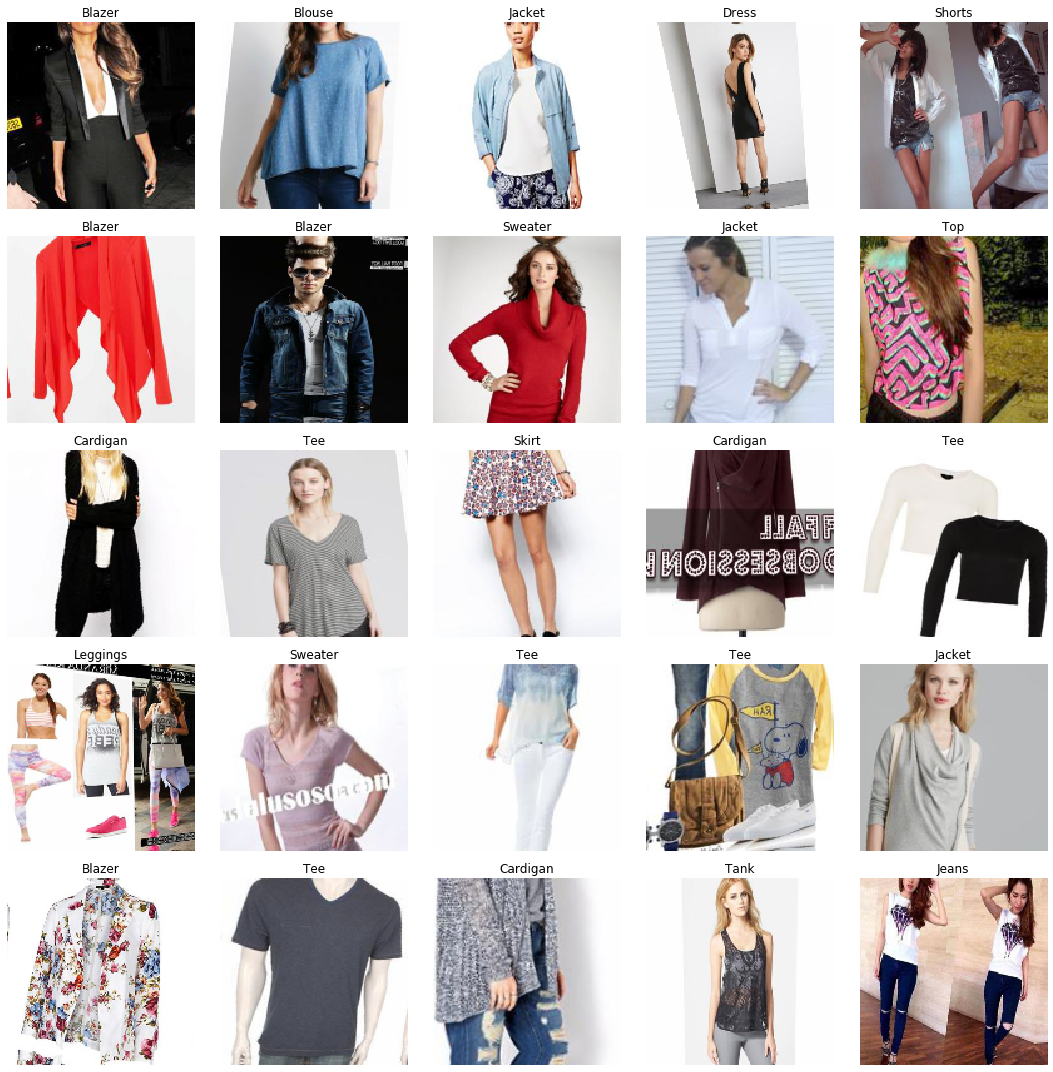

In [10]:
img_data.show_batch(rows=5, figsize=(15,15))

# Training the model
we are using transfer learning with a pre-trained ResNet-50 model and trianing this model for a specified number of epochs.

In [11]:
learn = cnn_learner(img_data, models.resnet50, metrics=accuracy)

In [12]:
learn.fit_one_cycle(3)

epoch,train_loss,valid_loss,accuracy,time
0,1.796612,1.626298,0.487875,19:11
1,1.566962,1.461752,0.545077,19:07
2,1.529254,1.417550,0.558366,19:03


In [13]:
learn.save('cat-resnet50-epoch3-size150')

In [ ]:
# def plot_loss_change(sched, sma=1, n_skip=20, y_lim=(-0.01,0.01)):
#     """
#     Plots rate of change of the loss function.
#     Parameters:
#         sched - learning rate scheduler, an instance of LR_Finder class.
#         sma - number of batches for simple moving average to smooth out the curve.
#         n_skip - number of batches to skip on the left.
#         y_lim - limits for the y axis.
#     """
#     derivatives = [0] * (sma + 1)
#     for i in range(1 + sma, len(learn.sched.lrs)):
#         derivative = (learn.sched.losses[i] - learn.sched.losses[i - sma]) / sma
#         derivatives.append(derivative)
        
#     plt.ylabel("d/loss")
#     plt.xlabel("learning rate (log scale)")
#     plt.plot(learn.sched.lrs[n_skip:], derivatives[n_skip:])
#     plt.xscale('log')
#     plt.ylim(y_lim)

# plot_loss_change(learn.sched, sma=20)

In [14]:
learn.lr_find()

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


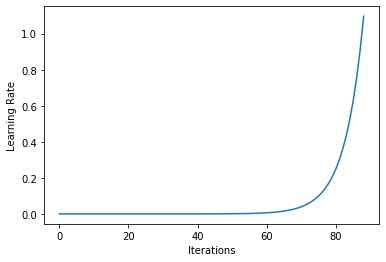

In [15]:
learn.recorder.plot_lr()

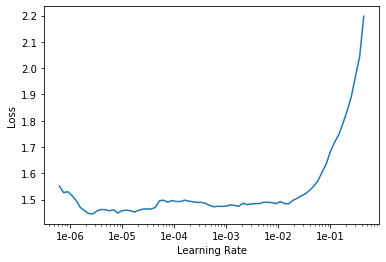

In [16]:
learn.recorder.plot()

In [17]:
learn.unfreeze()

In [18]:
learn.fit_one_cycle(4, max_lr=slice(1e-5,1e-3))

epoch,train_loss,valid_loss,accuracy,time
0,1.487400,1.377431,0.572836,25:33
1,1.348339,1.276831,0.602820,25:31
2,1.237646,1.195394,0.629836,25:27
3,1.119216,1.173135,0.639077,25:27


In [19]:
learn.export('cat-resnet50-epoch2-size150-5:3.pkl')

In [20]:
learn.freeze()

In [21]:
learn.fit_one_cycle(2)

epoch,train_loss,valid_loss,accuracy,time
0,1.143212,1.203139,0.632601,19:05
1,1.088176,1.180822,0.637559,19:09


In [23]:
learn.lr_find()

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


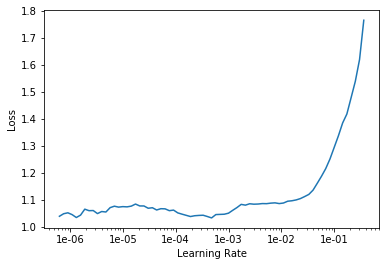

In [24]:
learn.recorder.plot()

In [25]:
learn.unfreeze()

In [26]:
learn.fit_one_cycle(2, max_lr=slice(1e-6,1e-4))

epoch,train_loss,valid_loss,accuracy,time
0,1.104010,1.178899,0.637559,25:28
1,1.054761,1.177084,0.639246,25:27


In [27]:
learn.export('cat-resnet50-epoch2-size150-6:4.pkl')

In [28]:
interp = ClassificationInterpretation.from_learner(learn)

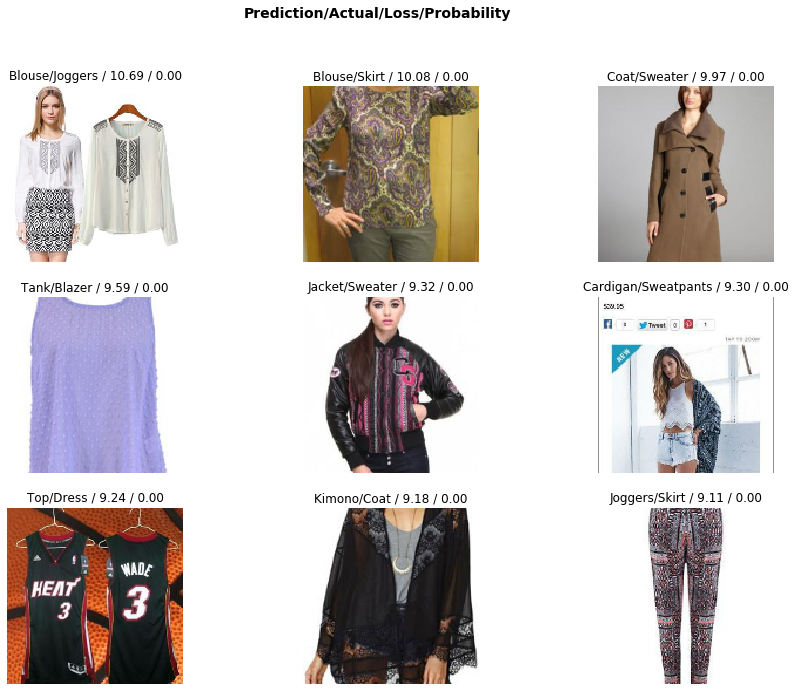

In [29]:
interp.plot_top_losses(9, figsize=(15,11))

In [30]:
def accuracy_topk(output, target, topk=(3,)):
    """Computes the precision@k for the specified values of k"""
    maxk = max(topk)
    batch_size = target.size(0)

    _, pred = output.topk(maxk, 1, True, True)
    pred = pred.t()
    correct = pred.eq(target.view(1, -1).expand_as(pred))

    res = []
    for k in topk:
        correct_k = correct[:k].view(-1).float().sum(0, keepdim=True)
        res.append(correct_k.mul_(100.0 / batch_size))
    return res

In [31]:
output, target = learn.get_preds(ds_type=DatasetType.Valid)
accuracy_topk(output, target, topk=(3,))

[tensor([86.6876])]

In [32]:
interp.most_confused(min_val=80)

[('Cardigan', 'Sweater', 348),
 ('Top', 'Blouse', 318),
 ('Sweater', 'Cardigan', 235),
 ('Top', 'Tank', 218),
 ('Blazer', 'Jacket', 192),
 ('Jacket', 'Blazer', 190),
 ('Tank', 'Tee', 189),
 ('Top', 'Tee', 187),
 ('Blouse', 'Top', 163),
 ('Jumpsuit', 'Dress', 163),
 ('Romper', 'Dress', 154),
 ('Top', 'Sweater', 151),
 ('Sweatpants', 'Joggers', 143),
 ('Tee', 'Blouse', 134),
 ('Tee', 'Tank', 133),
 ('Cutoffs', 'Shorts', 132),
 ('Joggers', 'Sweatpants', 127),
 ('Jacket', 'Cardigan', 126),
 ('Blouse', 'Tank', 125),
 ('Tee', 'Sweater', 112),
 ('Cardigan', 'Jacket', 108),
 ('Dress', 'Romper', 107),
 ('Blouse', 'Tee', 105),
 ('Shorts', 'Skirt', 104),
 ('Tank', 'Blouse', 101),
 ('Jumpsuit', 'Romper', 100),
 ('Skirt', 'Shorts', 98),
 ('Skirt', 'Dress', 96),
 ('Tee', 'Top', 95),
 ('Cardigan', 'Kimono', 94),
 ('Hoodie', 'Sweater', 91),
 ('Top', 'Skirt', 91),
 ('Blazer', 'Cardigan', 89),
 ('Joggers', 'Jeans', 85),
 ('Sweatshorts', 'Shorts', 85),
 ('Cardigan', 'Blouse', 83),
 ('Blouse', 'Skirt', 81

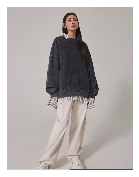

In [34]:
predict_img_path = "cat-pic-test.png"
show_image(open_image(predict_img_path))

In [36]:
category,classIndex,losses = learn.predict(open_image(predict_img_path))
# predictions = sorted(zip(data.classes, map(float, losses)), key=lambda p: p[1], reverse=True)
# print (predictions[:3])

In [39]:
print(category)
print(classIndex)
print(losses)

Sweater
tensor(16)
tensor([0.0182, 0.1099, 0.1810, 0.0019, 0.0007, 0.0010, 0.0062, 0.0420, 0.0057,
        0.0147, 0.0020, 0.0009, 0.0067, 0.0008, 0.0251, 0.0033, 0.4877, 0.0091,
        0.0065, 0.0081, 0.0098, 0.0586])
